
Modeling LSTM Architechture

# Import libraries

In [1]:
import os
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.optimizers import Adam, SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from bunch import bunchify

# apps
from helpers.model_adam import Model
print("import several libraries that are used as modeling deep lstm, including hard, pandas, numpy, and sklearn processing. \n** if this text appears, it means the library has been successfully installed")

Using TensorFlow backend.


import several libraries that are used as modeling deep lstm, including hard, pandas, numpy, and sklearn processing. 
** if this text appears, it means the library has been successfully installed


# Read Datasets
> **Notes**
>
> read the dataset of USD and JPY exchange rates against the rupiah, from 01-01-2014 to 01-01-2021

## USD-IDR


In [2]:
usd = pd.read_csv('datasets-usd.csv', index_col='Date')
print(f"Number of row and columns: {usd.shape}")
usd.head()

Number of row and columns: (1809, 4)


,Price,Open,High,Low
Date,,,,
2014-01-01,12170.0,12170.0,12170.0,12170.0
2014-01-02,12160.0,12195.0,12260.0,12150.0
2014-01-03,12170.0,12160.0,12245.0,12160.0
2014-01-06,12180.0,12195.0,12245.0,12180.0
2014-01-07,12237.5,12197.5,12277.5,12197.5


## JPY-IDR

In [3]:
jpy = pd.read_csv('dataset-jpy.csv', index_col='Date')
print(f"Number of row and column: {jpy.shape}")
jpy.head()

Number of row and column: (1828, 4)


,Price,Open,High,Low
Date,,,,
2014-01-01,115.64,115.48,115.71,115.33
2014-01-02,116.07,115.52,116.45,115.19
2014-01-03,116.07,115.90,117.58,115.84
2014-01-06,116.87,115.91,117.48,115.84
2014-01-07,116.97,116.75,117.64,116.43


# Data Single Fitur Configuration

Pada tahap ini data yang diproses hanya fitur data ***Price*** saja. fitur  ***Open***, ***High***, dan ***Low*** diabaikan.

> **Notes**
>
> perform the process of sharing training and test data, then the data will be normalized in standard form. 

## Data spliting (training & testing)

> **Notes**
> Pembagian data training dan testing menggunakan rasio 80% awal untuk training dan 20% terakhir sebagai testing

In [4]:
# split function

def split(data, n_train=0.8, n_test=0.2):
    train_set = data.Price.iloc[:round(n_train*len(data))].values
    test_set = data.Price.iloc[round( n_train*len(data) ):].values
    return train_set, test_set

In [5]:
datasets={
    "usd": {},
    "jpy": {}
}
datasets["usd"]["train_set"], datasets["usd"]["test_set"] = split(usd)
datasets["jpy"]["train_set"], datasets["jpy"]["test_set"] = split(jpy)

## Scaling data with MinMaxFunction [-1, 1]

\begin{equation}
X\_std = \frac{({X} - {X.min(axis=0)})} {(X.max(axis=0) - X.min(axis=0))}\\
\\
X\_scaled = X\_std * (max - min) + min\\
\end{equation}


In [6]:
# scaling data with MinMaxFunction
scaler = MinMaxScaler(feature_range=(-1,1))

# transform dataset to (len(data), 1)
datasets["usd"]["train_set"] = datasets["usd"]["train_set"].reshape(
    len(datasets["usd"]["train_set"]), 1
)
datasets["jpy"]["train_set"] = datasets["jpy"]["train_set"].reshape(
    len(datasets["jpy"]["train_set"]), 1
)

datasets["usd"]["test_set"] = datasets["usd"]["test_set"].reshape(
    len(datasets["usd"]["test_set"]), 1
)
datasets["jpy"]["test_set"] = datasets["jpy"]["test_set"].reshape(
    len(datasets["jpy"]["test_set"]), 1
)

datasets["usd"]["train_set"].shape

(1447, 1)

In [7]:
# scaling traning datasets
datasets["usd"]["train_set_scaled"] = scaler.fit_transform(datasets["usd"]["train_set"])
datasets["jpy"]["train_set_scaled"] = scaler.fit_transform(datasets["jpy"]["train_set"])

# scaling testing datasets
datasets["usd"]["test_set_scaled"] = scaler.fit_transform(datasets["usd"]["test_set"])
datasets["jpy"]["test_set_scaled"] = scaler.fit_transform(datasets["jpy"]["test_set"])

### Method of convert dictionary to object sets

In [8]:
# convert nested dictionaty to objects

class obj(object):
    def __init__(self, d):
        for a, b in d.items():
            if isinstance(b, (list, tuple)):
               setattr(self, a, [obj(x) if isinstance(x, dict) else x for x in b])
            else:
               setattr(self, a, obj(b) if isinstance(b, dict) else b)

In [9]:
data = obj(datasets)

In [10]:
data.jpy.train_set

array([[115.64],
       [116.07],
       [116.07],
       ...,
       [133.97],
       [133.83],
       [133.94]])

### Method of sliding window generator

In [11]:
def sliding_window(data, window, step_size=1):
        X_train = []
        y_train = []
        for i in range(window, data.shape[0]):
            X_train.append(data[i-window:i])
            y_train.append(data[i])
        X_train, y_train = np.array(X_train), np.array(y_train)
        return X_train, y_train
    

In [12]:
data.usd.windows = {}
data.jpy.windows = {}

In [13]:
inputs = [7,8,9,10]

for window in inputs:
    # usd training sliding window
    data.usd.windows[f'X_train{window}'], data.usd.windows[f'y_train{window}'] = sliding_window(
        data=data.usd.train_set_scaled,
        window=window
    )
    # usd testing sliding window
    data.usd.windows[f'X_test{window}'], data.usd.windows[f'y_test{window}'] = sliding_window(
        data=data.usd.test_set_scaled,
        window=window
    )
    # jpy training sliding window
    data.jpy.windows[f'X_train{window}'], data.jpy.windows[f'y_train{window}'] = sliding_window(
        data=data.jpy.train_set_scaled,
        window=window
    )
    # jpy testing sliding window
    data.jpy.windows[f'X_test{window}'], data.jpy.windows[f'y_test{window}'] = sliding_window(
        data=data.jpy.test_set_scaled,
        window=window
    )

In [14]:
data.usd.windows.keys()

dict_keys(['X_train7', 'y_train7', 'X_test7', 'y_test7', 'X_train8', 'y_train8', 'X_test8', 'y_test8', 'X_train9', 'y_train9', 'X_test9', 'y_test9', 'X_train10', 'y_train10', 'X_test10', 'y_test10'])

In [15]:
data.usd.windows=obj(data.usd.windows)
data.jpy.windows=obj(data.jpy.windows)

In [16]:
data.usd.windows.X_train7.shape

(1440, 7, 1)

# Build Model

| No. | Hyperparameters | Accuracy |
| :- | -: | :-: |
| 1* | Unit input/Sliding Window | [7,8,9,10] |
| 2* | Unit Neuron/Block LSTM | [1,2,3,4] |
| 3 | Unit Output/Target | 1 |
| 4 | Epochs | 100 |
| 5 | Hidden Layer (Stacked) | 3 |
| 6* | Optimizer | SGD, Adam |
| 7 | Beta Value | B1 = 0,9 & B2 = 0,99 |
| 8* | Learning Rate | 0,1; 0,01; 0,001; 0,0001 |
| 9 | Batch Size | 32 |
| 10* | Dropout | 0%, 20% |
| 11 | Activate Func | sigmoid & tanh |

## LR testing
Comparing learning rate performance (0.1, 0.01, 0.001, 0.0001)

### USD Model

#### LR 0.1

In [18]:
# set train and validation (USD IDR)
n_data = data.usd.windows.X_train7.shape[0]
X_train = data.usd.windows.X_train7[:round(n_data*0.8)]
y_train = data.usd.windows.y_train7[:round(n_data*0.8)]
X_validation = data.usd.windows.X_train7[round(n_data*0.8):]
y_validation = data.usd.windows.y_train7[round(n_data*0.8):]

In [18]:
lr01 = Model()
lr01.set_model(
    name_opt='Adam', 
    input_shape=data.usd.windows.X_train7.shape[1], 
    neuron_shape=1, 
    lr=0.1
)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
lr01.fitting(
    input_set =X_train,
    target_set=y_train,
    val_input =X_validation, 
    val_target=y_validation, 
    val_epoch =100
)


Train on 1152 samples, validate on 288 samples
Epoch 1/100
1152/1152 [==============================] - 1s 788us/step - loss: 0.0892 - mean_squared_error: 0.0892 - val_loss: 0.1271 - val_mean_squared_error: 0.1271
Epoch 2/100
1152/1152 [==============================] - 0s 203us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0603 - val_mean_squared_error: 0.0603
Epoch 3/100
1152/1152 [==============================] - 0s 230us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 4/100
1152/1152 [==============================] - 0s 188us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0229 - val_mean_squared_error: 0.0229
Epoch 5/100
1152/1152 [==============================] - 0s 189us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0177 - val_mean_squared_error: 0.0177
Epoch 6/100
1152/1152 [==============================] - 0s 198us/step - loss: 9.7843e-04 - mean_squared_error: 9.784

In [20]:
# serialize model to JSON
model_json = lr01.regressor.to_json()
with open("models/usd/lr01.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lr01.regressor.save_weights("models/usd/lr01.h5")
print("Saved model to disk")

Saved model to disk


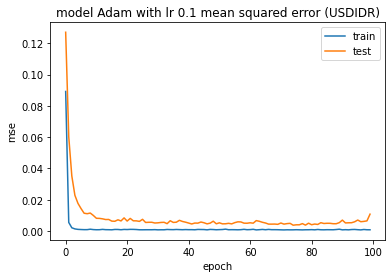

In [21]:
plt.plot(lr01.temp_history.history['mean_squared_error'])
plt.plot(lr01.temp_history.history['val_mean_squared_error'])
plt.title('model Adam with lr 0.1 mean squared error (USDIDR)')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.savefig('./images/usd/lr01.png')
plt.show()

#### LR 0.01

In [22]:
lr001 = Model()
lr001.set_model(
    name_opt='Adam',
    input_shape=data.usd.windows.X_train7.shape[1],
    neuron_shape=1,
    lr=0.01
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# n_data = data.usd.windows.X_train7.shape[0]
# X_train = data.usd.windows.X_train7[:round(n_data*0.8)]
# y_train = data.usd.windows.y_train7[:round(n_data*0.8)]
# X_validation = data.usd.windows.X_train7[round(n_data*0.8):]
# y_validation = data.usd.windows.y_train7[round(n_data*0.8):]

lr001.fitting(
    input_set =X_train,
    target_set=y_train,
    val_input =X_validation, 
    val_target=y_validation, 
    val_epoch =100
)

Train on 1152 samples, validate on 288 samples
Epoch 1/100
1152/1152 [==============================] - 1s 529us/step - loss: 0.1545 - mean_squared_error: 0.1545 - val_loss: 0.4710 - val_mean_squared_error: 0.4710
Epoch 2/100
1152/1152 [==============================] - 0s 181us/step - loss: 0.1271 - mean_squared_error: 0.1271 - val_loss: 0.4095 - val_mean_squared_error: 0.4095
Epoch 3/100
1152/1152 [==============================] - 0s 183us/step - loss: 0.0557 - mean_squared_error: 0.0557 - val_loss: 0.1383 - val_mean_squared_error: 0.1383
Epoch 4/100
1152/1152 [==============================] - 0s 177us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0952 - val_mean_squared_error: 0.0952
Epoch 5/100
1152/1152 [==============================] - 0s 180us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0533 - val_mean_squared_error: 0.0533
Epoch 6/100
1152/1152 [==============================] - 0s 182us/step - loss: 0.0026 - mean_squared_error: 0.0026 - v

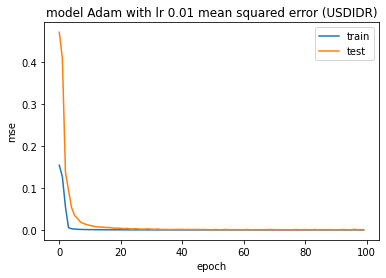

In [24]:
plt.plot(lr001.temp_history.history['mean_squared_error'])
plt.plot(lr001.temp_history.history['val_mean_squared_error'])
plt.title('model Adam with lr 0.01 mean squared error (USDIDR)')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.savefig('./images/usd/lr001.png')
plt.show()

In [25]:
# serialize model to JSON
model_json = lr001.regressor.to_json()
with open("models/usd/lr001.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lr001.regressor.save_weights("models/usd/lr001.h5")
print("Saved model to disk")

Saved model to disk


#### LR 0.001 

In [26]:
lr0001 = Model()
lr0001.set_model(
    name_opt='Adam',
    input_shape=data.usd.windows.X_train7.shape[1],
    neuron_shape=1,
    lr=0.001
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
# n_data = data.usd.windows.X_train7.shape[0]
# X_train = data.usd.windows.X_train7[:round(n_data*0.8)]
# y_train = data.usd.windows.y_train7[:round(n_data*0.8)]
# X_validation = data.usd.windows.X_train7[round(n_data*0.8):]
# y_validation = data.usd.windows.y_train7[round(n_data*0.8):]

lr0001.fitting(
    input_set =X_train,
    target_set=y_train,
    val_input =X_validation, 
    val_target=y_validation, 
    val_epoch =100
)

Train on 1152 samples, validate on 288 samples
Epoch 1/100
1152/1152 [==============================] - 1s 589us/step - loss: 0.2731 - mean_squared_error: 0.2731 - val_loss: 0.5544 - val_mean_squared_error: 0.5544
Epoch 2/100
1152/1152 [==============================] - 0s 188us/step - loss: 0.2386 - mean_squared_error: 0.2386 - val_loss: 0.5842 - val_mean_squared_error: 0.5842
Epoch 3/100
1152/1152 [==============================] - 0s 187us/step - loss: 0.2157 - mean_squared_error: 0.2157 - val_loss: 0.5937 - val_mean_squared_error: 0.5937
Epoch 4/100
1152/1152 [==============================] - 0s 178us/step - loss: 0.1998 - mean_squared_error: 0.1998 - val_loss: 0.5919 - val_mean_squared_error: 0.5919
Epoch 5/100
1152/1152 [==============================] - 0s 180us/step - loss: 0.1870 - mean_squared_error: 0.1870 - val_loss: 0.5746 - val_mean_squared_error: 0.5746
Epoch 6/100
1152/1152 [==============================] - 0s 185us/step - loss: 0.1763 - mean_squared_error: 0.1763 - v

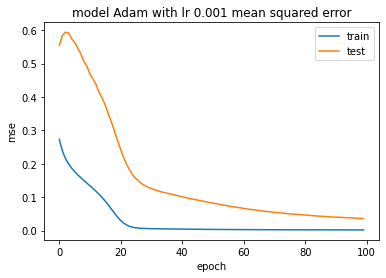

In [28]:
plt.plot(lr0001.temp_history.history['mean_squared_error'])
plt.plot(lr0001.temp_history.history['val_mean_squared_error'])
plt.title('model Adam with lr 0.001 mean squared error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.savefig('./images/usd/lr0001.png')
plt.show()

In [29]:
# serialize model to JSON
model_json = lr0001.regressor.to_json()
with open("models/usd/lr0001.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lr0001.regressor.save_weights("models/usd/lr0001.h5")
print("Saved model to disk")

Saved model to disk


#### LR 0.0001

In [30]:
lr00001 = Model()
lr00001.set_model(
    name_opt='Adam',
    input_shape=data.usd.windows.X_train7.shape[1],
    neuron_shape=1,
    lr=0.0001
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
# n_data = data.usd.windows.X_train7.shape[0]
# X_train = data.usd.windows.X_train7[:round(n_data*0.8)]
# y_train = data.usd.windows.y_train7[:round(n_data*0.8)]
# X_validation = data.usd.windows.X_train7[round(n_data*0.8):]
# y_validation = data.usd.windows.y_train7[round(n_data*0.8):]

lr00001.fitting(
    input_set =X_train,
    target_set=y_train,
    val_input =X_validation, 
    val_target=y_validation, 
    val_epoch =100
)

Train on 1152 samples, validate on 288 samples
Epoch 1/100
1152/1152 [==============================] - 1s 647us/step - loss: 0.0746 - mean_squared_error: 0.0746 - val_loss: 0.0904 - val_mean_squared_error: 0.0904
Epoch 2/100
1152/1152 [==============================] - 0s 182us/step - loss: 0.0728 - mean_squared_error: 0.0728 - val_loss: 0.0904 - val_mean_squared_error: 0.0904
Epoch 3/100
1152/1152 [==============================] - 0s 183us/step - loss: 0.0711 - mean_squared_error: 0.0711 - val_loss: 0.0904 - val_mean_squared_error: 0.0904
Epoch 4/100
1152/1152 [==============================] - 0s 182us/step - loss: 0.0695 - mean_squared_error: 0.0695 - val_loss: 0.0899 - val_mean_squared_error: 0.0899
Epoch 5/100
1152/1152 [==============================] - 0s 189us/step - loss: 0.0680 - mean_squared_error: 0.0680 - val_loss: 0.0892 - val_mean_squared_error: 0.0892
Epoch 6/100
1152/1152 [==============================] - 0s 242us/step - loss: 0.0664 - mean_squared_error: 0.0664 - v

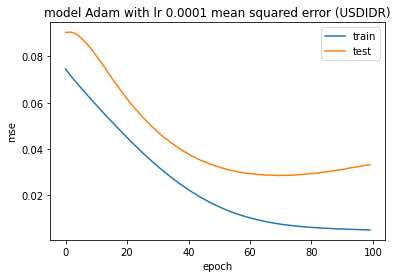

In [32]:
plt.plot(lr00001.temp_history.history['mean_squared_error'])
plt.plot(lr00001.temp_history.history['val_mean_squared_error'])
plt.title('model Adam with lr 0.0001 mean squared error (USDIDR)')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.savefig('./images/usd/lr00001.png')
plt.show()

In [33]:
# serialize model to JSON
model_json = lr00001.regressor.to_json()
with open("models/usd/lr00001.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lr001.regressor.save_weights("models/usd/lr00001.h5")
print("Saved model to disk")

Saved model to disk


### JPY Model

In [25]:
# set train and validation data (JPYIDR)

n_data = data.jpy.windows.X_train7.shape[0]
X_train = data.jpy.windows.X_train7[:round(n_data*0.8)]
y_train = data.jpy.windows.y_train7[:round(n_data*0.8)]
X_validation = data.jpy.windows.X_train7[round(n_data*0.8):]
y_validation = data.jpy.windows.y_train7[round(n_data*0.8):]

#### LR 0.1

In [18]:
lr01 = Model()
lr01.set_model(
    name_opt='Adam', 
    input_shape=data.jpy.windows.X_train7.shape[1], 
    neuron_shape=1, 
    lr=0.1
)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
lr01.fitting(
    input_set =X_train,
    target_set=y_train,
    val_input =X_validation, 
    val_target=y_validation, 
    val_epoch =100
)


Train on 1164 samples, validate on 291 samples
Epoch 1/100
1164/1164 [==============================] - 1s 515us/step - loss: 0.0366 - mean_squared_error: 0.0366 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 2/100
1164/1164 [==============================] - 0s 171us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 3/100
1164/1164 [==============================] - 0s 180us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 4/100
1164/1164 [==============================] - 0s 175us/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 5/100
1164/1164 [==============================] - 0s 182us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 6/100
1164/1164 [==============================] - 0s 179us/step - loss: 0.0029 - mean_squared_error: 0.0029 - 

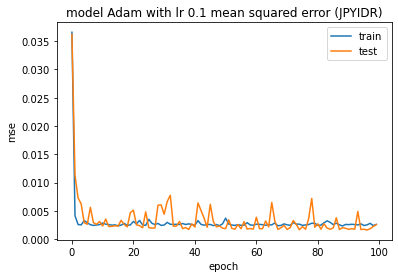

Saved model to disk


In [25]:
plt.plot(lr01.temp_history.history['mean_squared_error'])
plt.plot(lr01.temp_history.history['val_mean_squared_error'])
plt.title('model Adam with lr 0.1 mean squared error (JPYIDR)')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('./images/jpy/lr01.png')
plt.show()

# serialize model to JSON
model_json = lr01.regressor.to_json()
with open("models/jpy/lr01.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lr01.regressor.save_weights("models/jpy/lr01.h5")
print("Saved model to disk")

#### LR 0.01

In [26]:
lr001 = Model()
lr001.set_model(
    name_opt='Adam',
    input_shape=data.jpy.windows.X_train7.shape[1],
    neuron_shape=1,
    lr=0.01
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
n_data = data.jpy.windows.X_train7.shape[0]
X_train = data.jpy.windows.X_train7[:round(n_data*0.8)]
y_train = data.jpy.windows.y_train7[:round(n_data*0.8)]
X_validation = data.jpy.windows.X_train7[round(n_data*0.8):]
y_validation = data.jpy.windows.y_train7[round(n_data*0.8):]

lr001.fitting(
    input_set =X_train,
    target_set=y_train,
    val_input =X_validation, 
    val_target=y_validation, 
    val_epoch =100
)

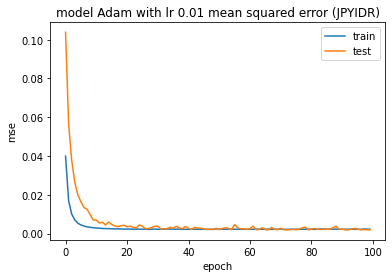

<Figure size 1440x720 with 0 Axes>

Saved model to disk


In [28]:
plt.plot(lr001.temp_history.history['mean_squared_error'])
plt.plot(lr001.temp_history.history['val_mean_squared_error'])
plt.title('model Adam with lr 0.01 mean squared error (JPYIDR)')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('./images/jpy/lr001.png')
plt.figure(figsize=(20,10))
plt.show()

# serialize model to JSON
model_json = lr001.regressor.to_json()
with open("models/jpy/lr001.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lr001.regressor.save_weights("models/jpy/lr001.h5")
print("Saved model to disk")

#### LR 0.001 

In [29]:
lr0001 = Model()
lr0001.set_model(
    name_opt='Adam',
    input_shape=data.jpy.windows.X_train7.shape[1],
    neuron_shape=1,
    lr=0.001
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
n_data = data.jpy.windows.X_train7.shape[0]
X_train = data.jpy.windows.X_train7[:round(n_data*0.8)]
y_train = data.jpy.windows.y_train7[:round(n_data*0.8)]
X_validation = data.jpy.windows.X_train7[round(n_data*0.8):]
y_validation = data.jpy.windows.y_train7[round(n_data*0.8):]

lr0001.fitting(
    input_set =X_train,
    target_set=y_train,
    val_input =X_validation, 
    val_target=y_validation, 
    val_epoch =100
)

Train on 1164 samples, validate on 291 samples
Epoch 1/100
1164/1164 [==============================] - 1s 631us/step - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.1578 - val_mean_squared_error: 0.1578
Epoch 2/100
1164/1164 [==============================] - 0s 195us/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.1170 - val_mean_squared_error: 0.1170
Epoch 3/100
1164/1164 [==============================] - 0s 197us/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0878 - val_mean_squared_error: 0.0878
Epoch 4/100
1164/1164 [==============================] - 0s 185us/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0645 - val_mean_squared_error: 0.0645
Epoch 5/100
1164/1164 [==============================] - 0s 187us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0511 - val_mean_squared_error: 0.0511
Epoch 6/100
1164/1164 [==============================] - 0s 188us/step - loss: 0.0072 - mean_squared_error: 0.0072 - v

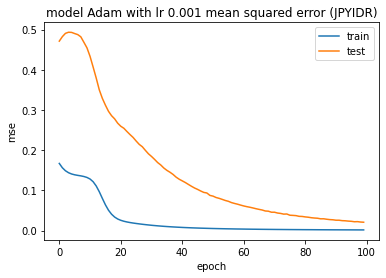

Saved model to disk


In [38]:
plt.plot(lr0001.temp_history.history['mean_squared_error'])
plt.plot(lr0001.temp_history.history['val_mean_squared_error'])
plt.title('model Adam with lr 0.001 mean squared error (JPYIDR)')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.savefig('./images/jpy/lr0001.png')
plt.show()


# serialize model to JSON
model_json = lr0001.regressor.to_json()
with open("models/jpy/lr0001.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lr0001.regressor.save_weights("models/jpy/lr0001.h5")
print("Saved model to disk")

#### LR 0.0001

In [34]:
lr00001 = Model()
lr00001.set_model(
    name_opt='Adam',
    input_shape=data.jpy.windows.X_train7.shape[1],
    neuron_shape=1,
    lr=0.0001
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
n_data = data.jpy.windows.X_train7.shape[0]
X_train = data.jpy.windows.X_train7[:round(n_data*0.8)]
y_train = data.jpy.windows.y_train7[:round(n_data*0.8)]
X_validation = data.jpy.windows.X_train7[round(n_data*0.8):]
y_validation = data.jpy.windows.y_train7[round(n_data*0.8):]

lr00001.fitting(
    input_set =X_train,
    target_set=y_train,
    val_input =X_validation, 
    val_target=y_validation, 
    val_epoch =100
)

Train on 1164 samples, validate on 291 samples
Epoch 1/100
1164/1164 [==============================] - 0s 191us/step - loss: 0.1313 - mean_squared_error: 0.1313 - val_loss: 0.4259 - val_mean_squared_error: 0.4259
Epoch 2/100
1164/1164 [==============================] - 0s 195us/step - loss: 0.1303 - mean_squared_error: 0.1303 - val_loss: 0.4262 - val_mean_squared_error: 0.4262
Epoch 3/100
1164/1164 [==============================] - 0s 191us/step - loss: 0.1293 - mean_squared_error: 0.1293 - val_loss: 0.4260 - val_mean_squared_error: 0.4260
Epoch 4/100
1164/1164 [==============================] - 0s 197us/step - loss: 0.1282 - mean_squared_error: 0.1282 - val_loss: 0.4259 - val_mean_squared_error: 0.4259
Epoch 5/100
1164/1164 [==============================] - 0s 202us/step - loss: 0.1271 - mean_squared_error: 0.1271 - val_loss: 0.4256 - val_mean_squared_error: 0.4256
Epoch 6/100
1164/1164 [==============================] - 0s 190us/step - loss: 0.1261 - mean_squared_error: 0.1261 - v

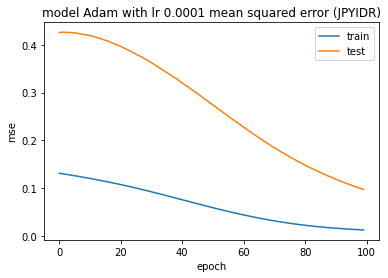

Saved model to disk


In [38]:
plt.plot(lr00001.temp_history.history['mean_squared_error'])
plt.plot(lr00001.temp_history.history['val_mean_squared_error'])
plt.title('model Adam with lr 0.0001 mean squared error (JPYIDR)')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.savefig('./images/jpy/lr00001.png')
plt.show()

# serialize model to JSON
model_json = lr00001.regressor.to_json()
with open("models/jpy/lr00001.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lr001.regressor.save_weights("models/jpy/lr00001.h5")
print("Saved model to disk")

### Summary!
---

- Pada nilai tukar USDIDR memiliki nilai LR paling optimal yaitu 0.001
- Sedangkan pada JPYIDR LR paling optimal yaitu 0.001

## Training Model (Adam vs SGD)
---
Skeman training model berdasarkan neuron dan jumlah hidden layer

### USD IDR

In [21]:
lr0001_sgd = Model()
lr0001_sgd.set_model(
    name_opt='SGD', 
    input_shape=data.usd.windows.X_train7.shape[1], 
    neuron_shape=1, 
    lr=0.001
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
lr0001_sgd.fitting(
    input_set =X_train,
    target_set=y_train,
    val_input =X_validation, 
    val_target=y_validation, 
    val_epoch =100
)


Train on 1152 samples, validate on 288 samples
Epoch 1/100
1152/1152 [==============================] - 1s 560us/step - loss: 0.2875 - mean_squared_error: 0.2875 - val_loss: 0.6891 - val_mean_squared_error: 0.6891
Epoch 2/100
1152/1152 [==============================] - 0s 190us/step - loss: 0.2824 - mean_squared_error: 0.2824 - val_loss: 0.7008 - val_mean_squared_error: 0.7008
Epoch 3/100
1152/1152 [==============================] - 0s 172us/step - loss: 0.2778 - mean_squared_error: 0.2778 - val_loss: 0.7113 - val_mean_squared_error: 0.7113
Epoch 4/100
1152/1152 [==============================] - 0s 172us/step - loss: 0.2736 - mean_squared_error: 0.2736 - val_loss: 0.7204 - val_mean_squared_error: 0.7204
Epoch 5/100
1152/1152 [==============================] - 0s 176us/step - loss: 0.2699 - mean_squared_error: 0.2699 - val_loss: 0.7285 - val_mean_squared_error: 0.7285
Epoch 6/100
1152/1152 [==============================] - 0s 174us/step - loss: 0.2665 - mean_squared_error: 0.2665 - 

Saved model to disk


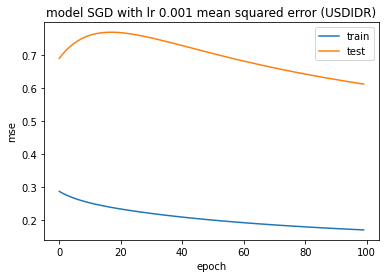

In [24]:
# serialize model to JSON
model_json = lr0001_sgd.regressor.to_json()
with open("models/usd/lr0001_sgd.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lr0001_sgd.regressor.save_weights("models/usd/lr0001_sgd.h5")
print("Saved model to disk")

plt.plot(lr0001_sgd.temp_history.history['mean_squared_error'])
plt.plot(lr0001_sgd.temp_history.history['val_mean_squared_error'])
plt.title('model SGD with lr 0.001 mean squared error (USDIDR)')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.savefig('./images/usd/lr0001_sgd.png')
plt.show()

### JPY IDR

In [27]:
lr0001_sgd = Model()
lr0001_sgd.set_model(
    name_opt='SGD', 
    input_shape=data.jpy.windows.X_train7.shape[1], 
    neuron_shape=1, 
    lr=0.001
)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
lr0001_sgd.fitting(
    input_set =X_train,
    target_set=y_train,
    val_input =X_validation, 
    val_target=y_validation, 
    val_epoch =100
)

Train on 1164 samples, validate on 291 samples
Epoch 1/100
1164/1164 [==============================] - 1s 529us/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.1475 - val_mean_squared_error: 0.1475
Epoch 2/100
1164/1164 [==============================] - 0s 175us/step - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.1455 - val_mean_squared_error: 0.1455
Epoch 3/100
1164/1164 [==============================] - 0s 181us/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.1433 - val_mean_squared_error: 0.1433
Epoch 4/100
1164/1164 [==============================] - 0s 193us/step - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.1412 - val_mean_squared_error: 0.1412
Epoch 5/100
1164/1164 [==============================] - 0s 184us/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.1391 - val_mean_squared_error: 0.1391
Epoch 6/100
1164/1164 [==============================] - 0s 182us/step - loss: 0.0206 - mean_squared_error: 0.0206 - v

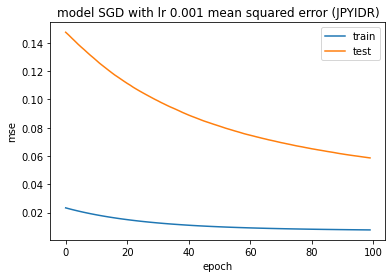

Saved model to disk


In [31]:
plt.plot(lr0001_sgd.temp_history.history['mean_squared_error'])
plt.plot(lr0001_sgd.temp_history.history['val_mean_squared_error'])
plt.title('model SGD with lr 0.001 mean squared error (JPYIDR)')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('./images/jpy/lr0001_sgd.png')
plt.show()

# serialize model to JSON
model_json = lr0001_sgd.regressor.to_json()
with open("models/jpy/lr0001_sgd.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lr0001_sgd.regressor.save_weights("models/jpy/lr0001_sgd.h5")
print("Saved model to disk")

## Training Model
---
Skeman training model berdasarkan neuron dan jumlah hidden layer

In [19]:
neurons = [1,2,3,4]
inputs = [7,8,9,10]
n_layer = 3

### USD Model

#### 1st Layer

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None

Train on 1152 samples, validate on 288 samples
Epoch 1/100
1152/1152 [==============================] - 1s 600us/step - loss: 0.1827 - mean_squared_error: 0.1827 - val_loss: 0.5477 - val_mean_squared_error: 0.5477
Epoch 2/100
1152/1152 [==============================] - 0s 177us/step - loss: 0.1708 - mean_squared_error: 0.1708 - val_loss: 0.5529 - val_mean_squared_error: 0.5529
Epoch 3/100
1152/1152 [=============================

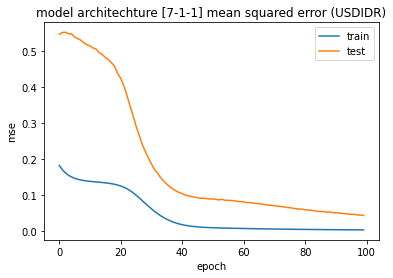

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 2)                 32        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________
None
Train on 1152 samples, validate on 288 samples
Epoch 1/100
1152/1152 [==============================] - 1s 530us/step - loss: 0.1112 - mean_squared_error: 0.1112 - val_loss: 0.2423 - val_mean_squared_error: 0.2423
Epoch 2/100
1152/1152 [==============================] - 0s 170us/step - loss: 0.0863 - mean_squared_error: 0.0863 - val_loss: 0.1741 - val_mean_squared_error: 0.1741
Epoch 3/100
1152/1152 [==============================] - 0s 168us/step - loss: 0.0572 - mean_squared_error: 0.0572 - val_loss: 0.1064 

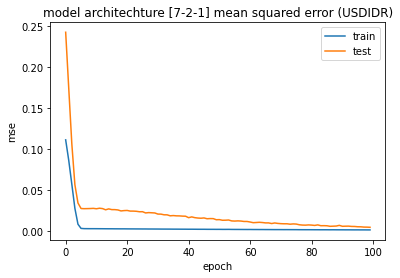

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 3)                 60        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
None
Train on 1152 samples, validate on 288 samples
Epoch 1/100
1152/1152 [==============================] - 1s 640us/step - loss: 0.2417 - mean_squared_error: 0.2417 - val_loss: 0.6245 - val_mean_squared_error: 0.6245
Epoch 2/100
1152/1152 [==============================] - 0s 185us/step - loss: 0.1945 - mean_squared_error: 0.1945 - val_loss: 0.5714 - val_mean_squared_error: 0.5714
Epoch 3/100
1152/1152 [==============================] - 0s 173us/step - loss: 0.1621 - mean_squared_error: 0.1621 - val_loss: 0.4971 

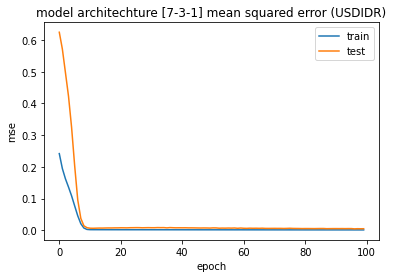

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None
Train on 1152 samples, validate on 288 samples
Epoch 1/100
1152/1152 [==============================] - 1s 572us/step - loss: 0.1378 - mean_squared_error: 0.1378 - val_loss: 0.4005 - val_mean_squared_error: 0.4005
Epoch 2/100
1152/1152 [==============================] - ETA: 0s - loss: 0.1075 - mean_squared_error: 0.10 - 0s 174us/step - loss: 0.1070 - mean_squared_error: 0.1070 - val_loss: 0.3451 - val_mean_squared_error: 0.3451
Epoch 3/100
1152/1152 [==============================] - 0s 178us/step - loss: 0

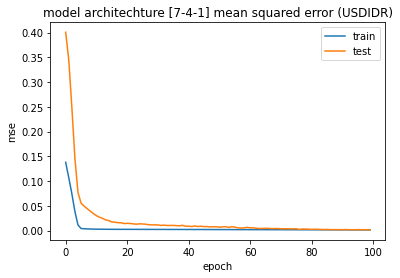

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
Train on 1151 samples, validate on 288 samples
Epoch 1/100
1151/1151 [==============================] - 1s 717us/step - loss: 0.5493 - mean_squared_error: 0.5493 - val_loss: 1.1924 - val_mean_squared_error: 1.1924
Epoch 2/100
1151/1151 [==============================] - 0s 197us/step - loss: 0.4940 - mean_squared_error: 0.4940 - val_loss: 1.1646 - val_mean_squared_error: 1.1646
Epoch 3/100
1151/1151 [==============================] - 0s 195us/step - loss: 0.4452 - mean_squared_error: 0.4452 - val_loss: 1.1372 

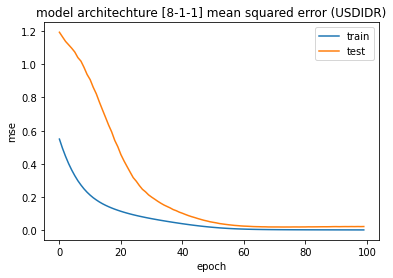

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 2)                 32        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________
None
Train on 1151 samples, validate on 288 samples
Epoch 1/100
1151/1151 [==============================] - 1s 647us/step - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.1567 - val_mean_squared_error: 0.1567
Epoch 2/100
1151/1151 [==============================] - 0s 200us/step - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.1302 - val_mean_squared_error: 0.1302
Epoch 3/100
1151/1151 [==============================] - 0s 191us/step - loss: 0.0252 - mean_squared_error: 0.0252 - val_loss: 0.1093 

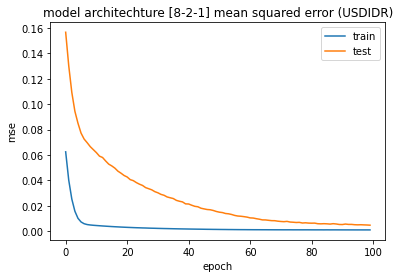

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 3)                 60        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
None
Train on 1151 samples, validate on 288 samples
Epoch 1/100
1151/1151 [==============================] - 1s 732us/step - loss: 0.1849 - mean_squared_error: 0.1849 - val_loss: 0.5593 - val_mean_squared_error: 0.5593
Epoch 2/100
1151/1151 [==============================] - 0s 193us/step - loss: 0.1691 - mean_squared_error: 0.1691 - val_loss: 0.5360 - val_mean_squared_error: 0.5360
Epoch 3/100
1151/1151 [==============================] - 0s 199us/step - loss: 0.1568 - mean_squared_error: 0.1568 - val_loss: 0.5019 

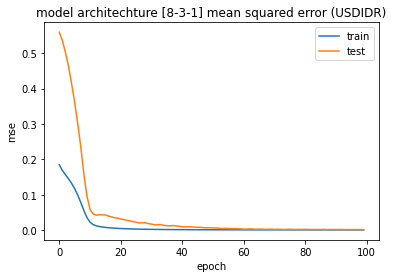

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None
Train on 1151 samples, validate on 288 samples
Epoch 1/100
1151/1151 [==============================] - 1s 856us/step - loss: 0.3119 - mean_squared_error: 0.3119 - val_loss: 0.8668 - val_mean_squared_error: 0.8668
Epoch 2/100
1151/1151 [==============================] - 0s 195us/step - loss: 0.2553 - mean_squared_error: 0.2553 - val_loss: 0.7815 - val_mean_squared_error: 0.7815
Epoch 3/100
1151/1151 [==============================] - 0s 202us/step - loss: 0.2183 - mean_squared_error: 0.2183 - val_loss: 0.698

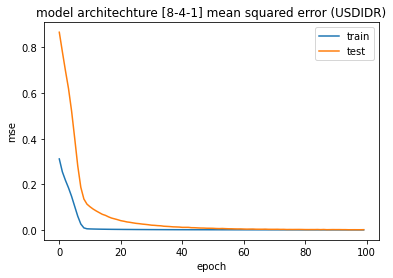

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
Train on 1150 samples, validate on 288 samples
Epoch 1/100
1150/1150 [==============================] - 1s 755us/step - loss: 0.1150 - mean_squared_error: 0.1150 - val_loss: 0.3405 - val_mean_squared_error: 0.3405
Epoch 2/100
1150/1150 [==============================] - 0s 209us/step - loss: 0.1039 - mean_squared_error: 0.1039 - val_loss: 0.3498 - val_mean_squared_error: 0.3498
Epoch 3/100
1150/1150 [==============================] - 0s 227us/step - loss: 0.0929 - mean_squared_error: 0.0929 - val_loss: 0.3461 

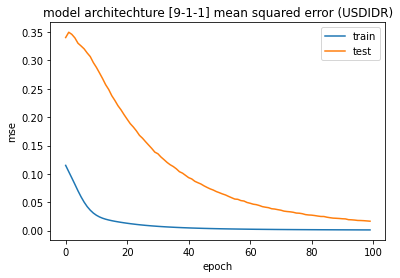

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 2)                 32        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________
None
Train on 1150 samples, validate on 288 samples
Epoch 1/100
1150/1150 [==============================] - 1s 820us/step - loss: 0.0766 - mean_squared_error: 0.0766 - val_loss: 0.0637 - val_mean_squared_error: 0.0637
Epoch 2/100
1150/1150 [==============================] - 0s 209us/step - loss: 0.0466 - mean_squared_error: 0.0466 - val_loss: 0.0509 - val_mean_squared_error: 0.0509
Epoch 3/100
1150/1150 [==============================] - 0s 214us/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0414

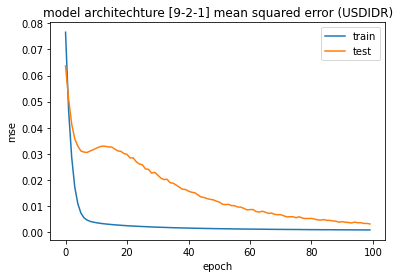

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 3)                 60        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
None
Train on 1150 samples, validate on 288 samples
Epoch 1/100
1150/1150 [==============================] - 1s 813us/step - loss: 0.2581 - mean_squared_error: 0.2581 - val_loss: 0.6110 - val_mean_squared_error: 0.6110
Epoch 2/100
1150/1150 [==============================] - 0s 214us/step - loss: 0.2099 - mean_squared_error: 0.2099 - val_loss: 0.5448 - val_mean_squared_error: 0.5448
Epoch 3/100
1150/1150 [==============================] - 0s 224us/step - loss: 0.1720 - mean_squared_error: 0.1720 - val_loss: 0.4494

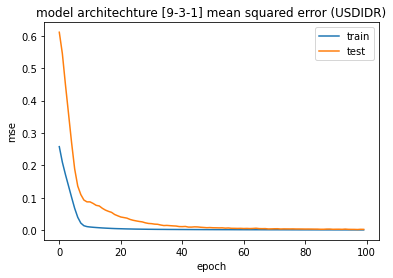

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 4)                 96        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None
Train on 1150 samples, validate on 288 samples
Epoch 1/100
1150/1150 [==============================] - 1s 863us/step - loss: 0.0892 - mean_squared_error: 0.0892 - val_loss: 0.1608 - val_mean_squared_error: 0.1608
Epoch 2/100
1150/1150 [==============================] - 0s 198us/step - loss: 0.0603 - mean_squared_error: 0.0603 - val_loss: 0.1044 - val_mean_squared_error: 0.1044
Epoch 3/100
1150/1150 [==============================] - 0s 202us/step - loss: 0.0332 - mean_squared_error: 0.0332 - val_loss: 0.05

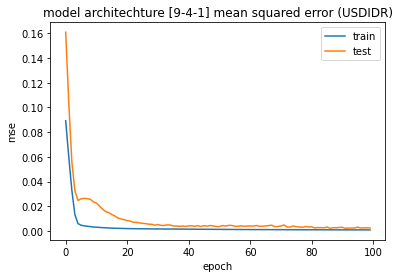

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
Train on 1150 samples, validate on 287 samples
Epoch 1/100
1150/1150 [==============================] - 2s 2ms/step - loss: 0.0918 - mean_squared_error: 0.0918 - val_loss: 0.2214 - val_mean_squared_error: 0.2214
Epoch 2/100
1150/1150 [==============================] - 0s 234us/step - loss: 0.0788 - mean_squared_error: 0.0788 - val_loss: 0.2200 - val_mean_squared_error: 0.2200
Epoch 3/100
1150/1150 [==============================] - 0s 284us/step - loss: 0.0660 - mean_squared_error: 0.0660 - val_loss: 0.2117 -

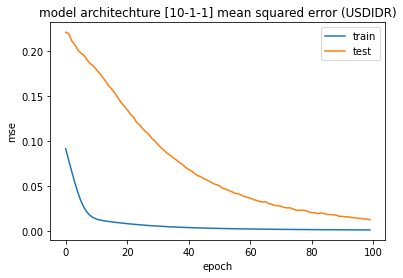

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 2)                 32        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________
None
Train on 1150 samples, validate on 287 samples
Epoch 1/100
1150/1150 [==============================] - 1s 1ms/step - loss: 0.1571 - mean_squared_error: 0.1571 - val_loss: 0.5851 - val_mean_squared_error: 0.5851
Epoch 2/100
1150/1150 [==============================] - 0s 243us/step - loss: 0.1171 - mean_squared_error: 0.1171 - val_loss: 0.5000 - val_mean_squared_error: 0.5000
Epoch 3/100
1150/1150 [==============================] - 0s 243us/step - loss: 0.0863 - mean_squared_error: 0.0863 - val_loss: 0.4149 -

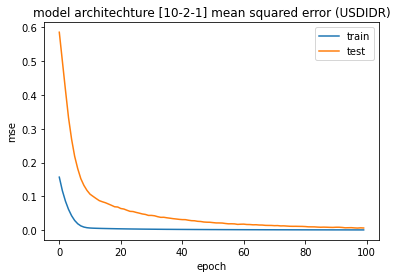

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 3)                 60        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
None
Train on 1150 samples, validate on 287 samples
Epoch 1/100
1150/1150 [==============================] - 1s 967us/step - loss: 0.3090 - mean_squared_error: 0.3090 - val_loss: 0.8800 - val_mean_squared_error: 0.8800
Epoch 2/100
1150/1150 [==============================] - 0s 238us/step - loss: 0.2573 - mean_squared_error: 0.2573 - val_loss: 0.8314 - val_mean_squared_error: 0.8314
Epoch 3/100
1150/1150 [==============================] - 0s 249us/step - loss: 0.2268 - mean_squared_error: 0.2268 - val_loss: 0.7633

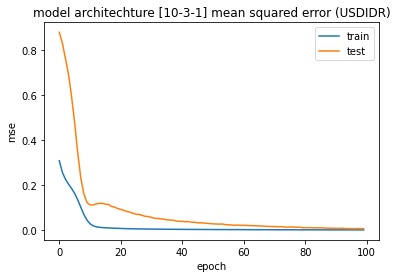

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 4)                 96        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None
Train on 1150 samples, validate on 287 samples
Epoch 1/100
1150/1150 [==============================] - 1s 1ms/step - loss: 0.1584 - mean_squared_error: 0.1584 - val_loss: 0.4038 - val_mean_squared_error: 0.4038
Epoch 2/100
1150/1150 [==============================] - 0s 224us/step - loss: 0.1198 - mean_squared_error: 0.1198 - val_loss: 0.3417 - val_mean_squared_error: 0.3417
Epoch 3/100
1150/1150 [==============================] - 0s 241us/step - loss: 0.0886 - mean_squared_error: 0.0886 - val_loss: 0.2724

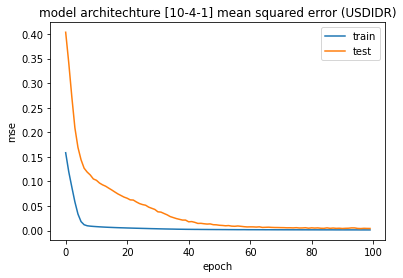

In [18]:
for slide in inputs:
    n_data  = data.usd.windows.__dict__[f"X_train{slide}"].shape[0]
    
    X_train = data.usd.windows.__dict__[f"X_train{slide}"][:round(n_data * .8)]
    y_train = data.usd.windows.__dict__[f"y_train{slide}"][:round(n_data * .8)]
    X_validation = data.usd.windows.__dict__[f"X_train{slide}"][round(n_data * .8):]
    y_validation = data.usd.windows.__dict__[f"y_train{slide}"][round(n_data * .8):]
    
    for neuron in neurons:
        model = Model()
        model.set_model(
            name_opt='Adam', 
            input_shape=data.usd.windows.__dict__[f"X_train{slide}"].shape[1], 
            neuron_shape=neuron, 
            lr=0.001
        )
        
        model.fitting(
            input_set =X_train,
            target_set=y_train,
            val_input =X_validation, 
            val_target=y_validation, 
            val_epoch =100
        )
                
        # serialize model to JSON
        model_json = model.regressor.to_json()
        with open(f"models/usd/model_{slide}_{neuron}.json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.regressor.save(f"models/usd/model_{slide}_{neuron}.h5")
        print("Saved model to disk")
        
        plt.plot(model.temp_history.history['mean_squared_error'])
        plt.plot(model.temp_history.history['val_mean_squared_error'])
        plt.title(f'model architechture [{slide}-{neuron}-1] mean squared error (USDIDR)')
        plt.ylabel('mse')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        plt.savefig(f'./images/usd/model_{slide}_{neuron}.png')
        plt.show()

#### 2nd Layer

In [56]:
hidden1 = 2
best_slide = 9

In [57]:
output = data.usd.windows.X_train9.shape[2]
models = {}
for neuron in neurons:
    model = Sequential()
    model.add(LSTM(
        hidden1, 
        input_shape=(9, 1),
        return_sequences=True
    ))
    model.add(LSTM(
        neuron,
    ))
    model.add(Dense(1))
    models[f"{best_slide}_{hidden1}_{neuron}"] = model

In [58]:
models

{'9_2_1': <keras.engine.sequential.Sequential at 0x7fbc47fdcdd8>,
 '9_2_2': <keras.engine.sequential.Sequential at 0x7fbc478bc4e0>,
 '9_2_3': <keras.engine.sequential.Sequential at 0x7fbc471056a0>,
 '9_2_4': <keras.engine.sequential.Sequential at 0x7fbc47027860>}

In [59]:
modelpath = './models/usd/'
for key, value in models.items():
    plot_model(model=value, show_shapes=True, to_file=f"./images/usd/shape_model_{key}.png")
    print(f"saving figure model {key} successfully.")

saving figure model 9_2_1 successfully.
saving figure model 9_2_2 successfully.
saving figure model 9_2_3 successfully.
saving figure model 9_2_4 successfully.


In [60]:
data.usd.windows.X_train9[:round(1438*.8)].shape

(1150, 9, 1)

In [61]:
data.usd.windows.X_train9[round(1438*.8):].shape

(288, 9, 1)

./models/usd/model_9_2_1.h5
Train on 1150 samples, validate on 288 samples
Epoch 1/100
1150/1150 [==============================] - 2s 2ms/step - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.0363 - val_mean_squared_error: 0.0363
Epoch 2/100
1150/1150 [==============================] - 0s 358us/step - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 3/100
1150/1150 [==============================] - 0s 381us/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0188 - val_mean_squared_error: 0.0188
Epoch 4/100
1150/1150 [==============================] - 0s 367us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0224 - val_mean_squared_error: 0.0224
Epoch 5/100
1150/1150 [==============================] - 0s 370us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0271 - val_mean_squared_error: 0.0271
Epoch 6/100
1150/1150 [==============================] - 0s 372us/step - loss: 0.0061 - mean

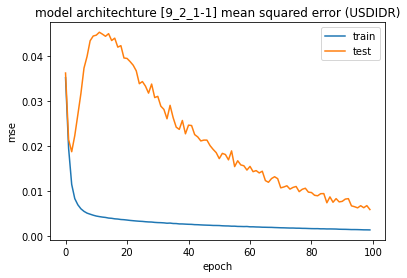

./models/usd/model_9_2_2.h5
Train on 1150 samples, validate on 288 samples
Epoch 1/100
1150/1150 [==============================] - 2s 1ms/step - loss: 0.2710 - mean_squared_error: 0.2710 - val_loss: 0.8012 - val_mean_squared_error: 0.8012
Epoch 2/100
1150/1150 [==============================] - 0s 349us/step - loss: 0.2214 - mean_squared_error: 0.2214 - val_loss: 0.7555 - val_mean_squared_error: 0.7555
Epoch 3/100
1150/1150 [==============================] - 0s 360us/step - loss: 0.1927 - mean_squared_error: 0.1927 - val_loss: 0.6672 - val_mean_squared_error: 0.6672
Epoch 4/100
1150/1150 [==============================] - 0s 362us/step - loss: 0.1728 - mean_squared_error: 0.1728 - val_loss: 0.5941 - val_mean_squared_error: 0.5941
Epoch 5/100
1150/1150 [==============================] - 0s 360us/step - loss: 0.1553 - mean_squared_error: 0.1553 - val_loss: 0.5002 - val_mean_squared_error: 0.5002
Epoch 6/100
1150/1150 [==============================] - 0s 366us/step - loss: 0.1352 - mean

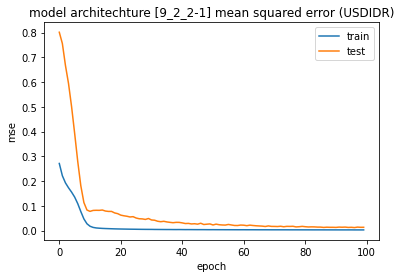

./models/usd/model_9_2_3.h5
Train on 1150 samples, validate on 288 samples
Epoch 1/100
1150/1150 [==============================] - 2s 1ms/step - loss: 0.0929 - mean_squared_error: 0.0929 - val_loss: 0.1854 - val_mean_squared_error: 0.1854
Epoch 2/100
1150/1150 [==============================] - 0s 354us/step - loss: 0.0635 - mean_squared_error: 0.0635 - val_loss: 0.1535 - val_mean_squared_error: 0.1535
Epoch 3/100
1150/1150 [==============================] - 0s 364us/step - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.1168 - val_mean_squared_error: 0.1168
Epoch 4/100
1150/1150 [==============================] - 0s 366us/step - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0938 - val_mean_squared_error: 0.0938
Epoch 5/100
1150/1150 [==============================] - 0s 362us/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0893 - val_mean_squared_error: 0.0893
Epoch 6/100
1150/1150 [==============================] - 0s 355us/step - loss: 0.0095 - mean

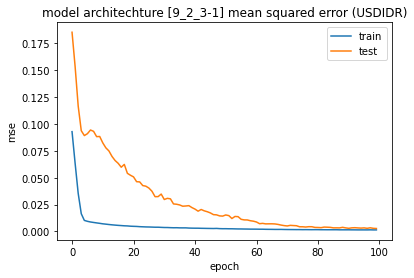

./models/usd/model_9_2_4.h5
Train on 1150 samples, validate on 288 samples
Epoch 1/100
1150/1150 [==============================] - 2s 2ms/step - loss: 0.0763 - mean_squared_error: 0.0763 - val_loss: 0.2610 - val_mean_squared_error: 0.2610
Epoch 2/100
1150/1150 [==============================] - 0s 358us/step - loss: 0.0326 - mean_squared_error: 0.0326 - val_loss: 0.1461 - val_mean_squared_error: 0.1461
Epoch 3/100
1150/1150 [==============================] - 0s 349us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0778 - val_mean_squared_error: 0.0778
Epoch 4/100
1150/1150 [==============================] - 0s 361us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0682 - val_mean_squared_error: 0.0682
Epoch 5/100
1150/1150 [==============================] - 0s 350us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0619 - val_mean_squared_error: 0.0619
Epoch 6/100
1150/1150 [==============================] - 0s 357us/step - loss: 0.0042 - mean

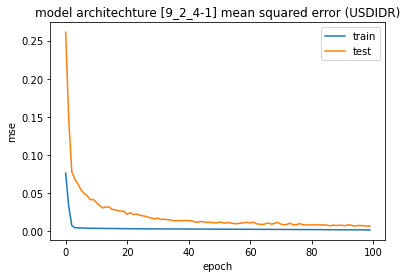

In [63]:
# fitting
num_of_train = data.usd.windows.X_train9.shape[0]
X_train = data.usd.windows.X_train9[:round(num_of_train*.8)]
y_train = data.usd.windows.y_train9[:round(num_of_train*.8)]

X_val = data.usd.windows.X_train9[round(num_of_train*.8):]
y_val = data.usd.windows.y_train9[round(num_of_train*.8):]
for key, value in models.items():
    modelfile = f'./models/usd/model_{key}.h5'
    if os.path.exists(modelfile):
        print(f"models/usd/model_{key}.h5 is exists")
    else:
        print(modelfile)
        
        value.compile(loss='mean_squared_error', metrics=['mean_squared_error'], optimizer='adam')
        value.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))
        value.save(modelfile)
        
        model_json = value.to_json()
        with open(f"models/usd/model_{key}.json", "w") as json_file:
            json_file.write(model_json)
        print("Saved model to disk")
        
        plt.plot(value.history.history['mean_squared_error'])
        plt.plot(value.history.history['val_mean_squared_error'])
        plt.title(f'model architechture [{key}-1] mean squared error (USDIDR)')
        plt.ylabel('mse')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        plt.savefig(f'./images/usd/model_{key}.png')
        plt.show()
    

#### 3rd Layer

In [20]:
hidden1 = 2
hidden2 = 1
best_slide = 9

In [21]:
output = data.usd.windows.X_train9.shape[2]
models = {}
for neuron in neurons:
    model = Sequential()
    model.add(LSTM(
        units=hidden1, 
        input_shape=(1, 9),
        return_sequences=True
    ))
    model.add(LSTM(
        units=hidden2,
        return_sequences=True
    ))
    model.add(LSTM(
        neuron,
    ))
    model.add(Dense(1))
    models[f"{best_slide}_{hidden1}_{hidden2}_{neuron}"] = model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
models

In [104]:
modelpath = './models/usd/'
for key, value in models.items():
    plot_model(model=value, show_shapes=True, to_file=f"./images/usd/shape_model_{key}.png")
    print(f"saving figure model {key} successfully.")

saving figure model 9_2_1_1 successfully.
saving figure model 9_2_1_2 successfully.
saving figure model 9_2_1_3 successfully.
saving figure model 9_2_1_4 successfully.


In [105]:
data.usd.windows.X_train9[:round(1438*.8)].shape

(1150, 9, 1)

In [106]:
data.usd.windows.X_train9[round(1438*.8):].shape

(288, 9, 1)

In [112]:
# fitting
num_of_train = data.usd.windows.X_train9.shape[0]
X_train = data.usd.windows.X_train9[:round(num_of_train*.8)]
y_train = data.usd.windows.y_train9[:round(num_of_train*.8)]

# X_train = np.reshape(X_train.shape[0], 1, X_train.shape[2])
# y_train = np.reshape(y_train.shape[0], 1, y_train.shape[2])

X_val = data.usd.windows.X_train9[round(num_of_train*.8):]
y_val = data.usd.windows.y_train9[round(num_of_train*.8):]

# X_val = np.reshape(X_val.shape[0], 1, X_val.shape[2])
# y_val = np.reshape(y_val.shape[0], 1, y_val.shape[2])


for key, value in models.items():
    modelfile = f'./models/usd/model_{key}.h5'
    if os.path.exists(modelfile):
        print(f"models/usd/model_{key}.h5 is exists")
    else:
        print(modelfile)
        
        value.compile(loss='mean_squared_error', metrics=['mean_squared_error'], optimizer='adam')
        value.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))
        value.save(modelfile)
        
        model_json = value.to_json()
        with open(f"models/usd/model_{key}.json", "w") as json_file:
            json_file.write(model_json)
        print("Saved model to disk")
        
        plt.plot(value.history.history['mean_squared_error'])
        plt.plot(value.history.history['val_mean_squared_error'])
        plt.title(f'model architechture [{key}-1] mean squared error (USDIDR)')
        plt.ylabel('mse')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        plt.savefig(f'./images/usd/model_{key}.png')
        plt.show()
    

TypeError: order must be str, not int

In [110]:
X_train.shape

(1150, 9, 1)

#### 4th Layer

### JPY Model

#### 1st Layer

#### 2nd Layer

#### 3rd Layer